<a href="https://colab.research.google.com/github/adamgrzanek/CV_damaged_car_detection/blob/main/Project_CV_damaged_car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
import plotly.offline as po
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import cv2
import imutils
from google.colab.patches import cv2_imshow
from datetime import datetime
import pytz
import pickle
from imutils import paths
import shutil
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

In [ ]:
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.15.0


## Wczytanie danych

In [ ]:
!pwd

/content


In [ ]:
!ls

model_transfer_VGG_16___20_02_2024_10_51.hdf5  sample_data  test_images_19_01_2024.zip


In [ ]:
! unzip cars_image.zip

In [ ]:
base_path = 'cars_image'

cars_dir = os.listdir(base_path)
print(cars_dir)

['ok_cars', 'damaged_cars']


In [ ]:
# ujednolicenie nazw plików (ok_cars/0001.jpg)

for dir in cars_dir:
    #print(dir)
    path = os.path.join(base_path, dir)
    images = paths.list_images(path)
    print(path)
    for n, img in enumerate(sorted(images), start=1):
        #print(n, image)
        if img.split('.')[-1] in ['jpeg', 'jpg', 'png']:
            new_file_name = os.path.join(path, f'{n:04}.jpg')
            os.rename(img, new_file_name)

ok_cars
cars_image/ok_cars
damaged_cars
cars_image/damaged_cars


In [ ]:
ok_cars_path = base_path + '/' + 'ok_cars'
damaged_cars_path = base_path + '/' + 'damaged_cars'


print(f'Ilość zdjęć w katalogu {ok_cars_path}: {len(os.listdir(ok_cars_path))}')
print(f'Ilość zdjęć w katalogu {damaged_cars_path}: {len(os.listdir(damaged_cars_path))}')

Ilość zdjęć w katalogu cars_image/ok_cars: 1771
Ilość zdjęć w katalogu cars_image/damaged_cars: 826


## Eksploracja wczytanych zdjęć

cars_image/ok_cars/1631.jpg


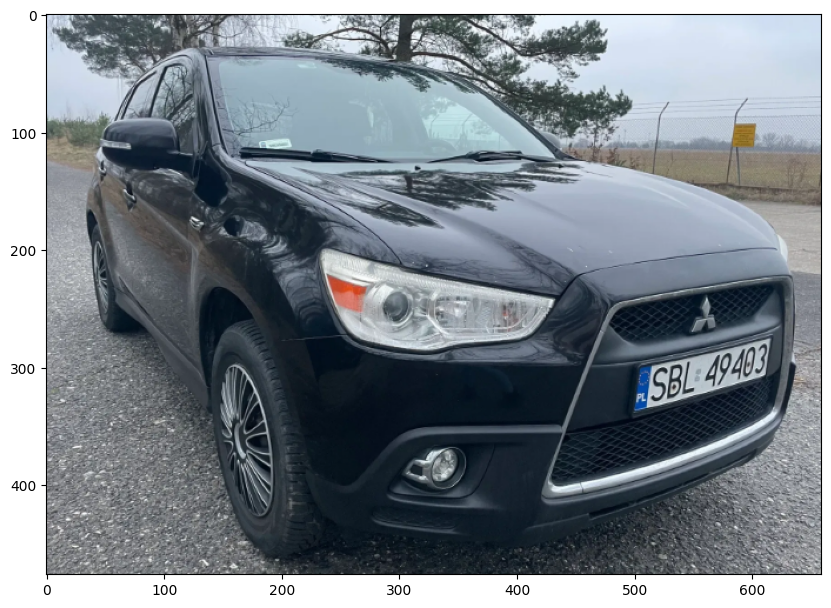

In [ ]:
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=eFN7-fUKs-Bu
#from tensorflow.keras.preprocessing import image
#@title Wybierz indeks przykładowego zdjęcia auta bez uszkodzeń:

index = 1631 #@param {type:'slider', min:1, max:1631}
img_path = ok_cars_path + f'/{index:04}.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
print(img_path)

cars_image/damaged_cars/0770.jpg


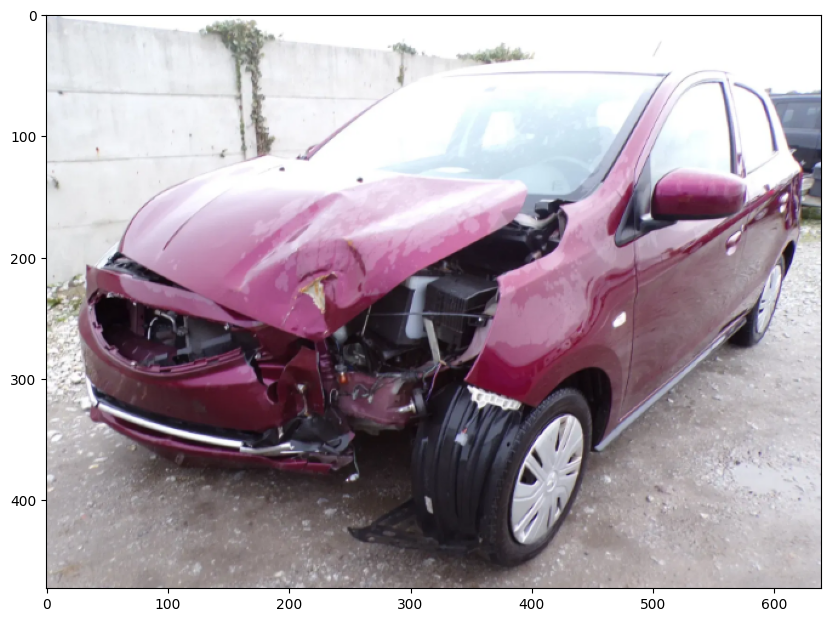

In [ ]:
# https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=eFN7-fUKs-Bu

#@title Wybierz indeks przykładowego zdjęcia uszkodzonego auta:

index = 770 #@param {type:'slider', min:1, max:770}
img_path = damaged_cars_path + f'/{index:04}.jpg'

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
print(img_path)

## Podział danych (Tworzenie 3 katalogów i kopiowanie plików)

In [ ]:
cars_dir

['ok_cars', 'damaged_cars']

In [ ]:
CLS_1 = cars_dir[0] # 'ok_cars'
CLS_2 = cars_dir[1] # 'damaged_cars'
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
DATA_DIR = r'./splitted_images'

raw_no_of_files = {}
classes = [CLS_1, CLS_2]

number_of_samples = [(dir, len(os.listdir(os.path.join(base_path, dir)))) for dir in classes]
print(number_of_samples)  # [('damaged_cars', 444), ('ok_cars', 1461)]


if not os.path.exists(DATA_DIR): os.mkdir(DATA_DIR)

# Katalogi do zbiorów: train, valid, test
train_dir = os.path.join(DATA_DIR, 'train')
valid_dir = os.path.join(DATA_DIR, 'valid')
test_dir = os.path.join(DATA_DIR, 'test')

train_cls_1_dir = os.path.join(train_dir, CLS_1)
valid_cls_1_dir = os.path.join(valid_dir, CLS_1)
test_cls_1_dir = os.path.join(test_dir, CLS_1)

train_cls_2_dir = os.path.join(train_dir, CLS_2)
valid_cls_2_dir = os.path.join(valid_dir, CLS_2)
test_cls_2_dir = os.path.join(test_dir, CLS_2)

for dir in (train_dir, valid_dir, test_dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

for dir in (train_cls_1_dir, valid_cls_1_dir, test_cls_1_dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

for dir in (train_cls_2_dir, valid_cls_2_dir, test_cls_2_dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

print('\n', '-' * 40)
print('[INFO] Wczytanie nazw plików...')
cls_1_names = os.listdir(os.path.join(base_path, CLS_1))
cls_2_names = os.listdir(os.path.join(base_path, CLS_2))

print('[INFO] Walidacja poprawności nazw...')
cls_1_names = [fname for fname in cls_1_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
cls_2_names = [fname for fname in cls_2_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

# Przetasowanie nazw plików (nie korzystamy aby zachować powtarzalność)
# np.random.shuffle(cls_1_names)
# np.random.shuffle(cls_2_names)

print('\n', '-' * 40)
print(f'[INFO] Liczba obrazów w zbiorze {CLS_1}: {len(cls_1_names)}')
print(f'[INFO] Liczba obrazów w zbiorze {CLS_2}: {len(cls_2_names)}')

train_idx_cls_1 = int(TRAIN_RATIO * len(cls_1_names))
valid_idx_cls_1 = train_idx_cls_1 + int(VALID_RATIO * len(cls_1_names))

train_idx_cls_2 = int(TRAIN_RATIO * len(cls_2_names))
valid_idx_cls_2 = train_idx_cls_2 + int(VALID_RATIO * len(cls_2_names))

print('\n', '-' * 40)
print('[INFO] Kopiowanie plików do katalogów docelowych...')
for i, fname in enumerate(cls_1_names):
    if i <= train_idx_cls_1:
        src = os.path.join(base_path, CLS_1, fname)
        dst = os.path.join(train_cls_1_dir, fname)
        shutil.copyfile(src, dst)
    if train_idx_cls_1 < i <= valid_idx_cls_1:
        src = os.path.join(base_path, CLS_1, fname)
        dst = os.path.join(valid_cls_1_dir, fname)
        shutil.copyfile(src, dst)
    if valid_idx_cls_1 < i <= len(cls_1_names):
        src = os.path.join(base_path, CLS_1, fname)
        dst = os.path.join(test_cls_1_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(cls_2_names):
    if i <= train_idx_cls_2:
        src = os.path.join(base_path, CLS_2, fname)
        dst = os.path.join(train_cls_2_dir, fname)
        shutil.copyfile(src, dst)
    if train_idx_cls_2 < i <= valid_idx_cls_2:
        src = os.path.join(base_path, CLS_2, fname)
        dst = os.path.join(valid_cls_2_dir, fname)
        shutil.copyfile(src, dst)
    if valid_idx_cls_2 < i <= len(cls_2_names):
        src = os.path.join(base_path, CLS_2, fname)
        dst = os.path.join(test_cls_2_dir, fname)
        shutil.copyfile(src, dst)

print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze treningowym: {len(os.listdir(train_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze validacyjnym: {len(os.listdir(valid_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze testowym: {len(os.listdir(test_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze treningowym: {len(os.listdir(train_cls_2_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze validacyjnym: {len(os.listdir(valid_cls_2_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze testowym: {len(os.listdir(test_cls_2_dir))}')

[('ok_cars', 1771), ('damaged_cars', 826)]

 ----------------------------------------
[INFO] Wczytanie nazw plików...
[INFO] Walidacja poprawności nazw...

 ----------------------------------------
[INFO] Liczba obrazów w zbiorze ok_cars: 1771
[INFO] Liczba obrazów w zbiorze damaged_cars: 826

 ----------------------------------------
[INFO] Kopiowanie plików do katalogów docelowych...
[INFO] Liczba obrazów klasy ok_cars w zbiorze treningowym: 1240
[INFO] Liczba obrazów klasy ok_cars w zbiorze validacyjnym: 354
[INFO] Liczba obrazów klasy ok_cars w zbiorze testowym: 177
[INFO] Liczba obrazów klasy damaged_cars w zbiorze treningowym: 579
[INFO] Liczba obrazów klasy damaged_cars w zbiorze validacyjnym: 165
[INFO] Liczba obrazów klasy damaged_cars w zbiorze testowym: 82


## Stałe

In [ ]:
LEARNING_RATE = 0.001

EPOCHS = 50
BATCH_SIZE = 32

INPUT_SHAPE = (224, 224, 3)

TRAIN_DIR = 'splitted_images/train'
VALID_DIR = 'splitted_images/valid'
TEST_DIR = 'splitted_images/test'

In [ ]:
if not os.path.exists('output'):
    os.mkdir('output')

## Funkcje

In [ ]:
# wykres historii uczenia
def plot_hist(history, filename, show_plot=False):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = make_subplots(rows=2, cols=1, subplot_titles=('Accuracy', 'Loss'))

    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='train_accuracy',
                             mode='markers+lines', marker_color='#f29407'), row=1, col=1)
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='valid_accuracy',
                             mode='markers+lines', marker_color='#0771f2'), row=1, col=1)
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='train_loss',
                             mode='markers+lines', marker_color='#f29407'), row=2, col=1)
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='valid_loss',
                             mode='markers+lines', marker_color='#0771f2'), row=2, col=1)

    fig.update_xaxes(title_text='Liczba epok', row=1, col=1)
    fig.update_xaxes(title_text='Liczba epok', row=2, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=1)
    fig.update_yaxes(title_text='Loss', row=2, col=1)
    fig.update_layout(width=1200, height=900, title=f"Metrics: {MODEL_NAME}")

    po.plot(fig, filename=filename, auto_open=False)

    if show_plot:
        #return po.plot(fig)
        fig.show()


In [ ]:
def display_augmented_images(directory, index):

    #fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    fnames = sorted([os.path.join(directory, fname) for fname in os.listdir(directory)])
    img_path = fnames[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(20, 14))
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

In [ ]:
def check_model(model, directory, input_shape, confidence=0.5):

    # tworzymy generator
    datagen = ImageDataGenerator(
        rescale=1. / 255.)

    generator = datagen.flow_from_directory(
        directory=directory,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=1,
        class_mode='binary',
        shuffle=False)

    # metoda predict
    y_prob = model.predict(generator, workers=1) # przewiduje dane z generatora
    y_prob = y_prob.ravel()

    # pobranie prawdziwych klas
    y_true = generator.classes

    # df z wynikami
    predictions = pd.DataFrame({'y_prob': y_prob, 'y_true': y_true}, index=generator.filenames) # indeks - nazwa pliku
    predictions['y_pred'] = predictions['y_prob'].apply(lambda x: 1 if x > confidence else 0)     # przydzielenie do klasy (0 lub 1) wyników z kolumny y_prob
    predictions['is_incorrect'] = (predictions['y_true'] != predictions['y_pred']) * 1     # czy źle sklasyfikowany


    print('\n====')
    label_map = generator.class_indices
    print(label_map) # {'damaged_cars': 0, 'ok_cars': 1}
    print('====')

    # dodanie etykiet do df
    label_map = dict((v, k) for k, v in label_map.items())
    predictions['class'] = predictions['y_pred'].apply(lambda x: label_map[x]) # nazwa klasy


    # fragment df ze źle sklasyfikowanymi obrazami
    errors = predictions[predictions['is_incorrect'] == 1]['y_prob']

    # przydzielone klasy np.array([0, 0, 1,...,0]) do wyświetlenia raportów
    y_pred = predictions['y_pred'].values

    print(f'\n[INFO] Macierz konfuzji:\n{confusion_matrix(y_true, y_pred)}')
    print(f'\n[INFO] Raport klasyfikacji:\n{classification_report(y_true, y_pred, target_names=generator.class_indices.keys())}')
    print(f'\n[INFO] Dokładność modelu: {accuracy_score(y_true, y_pred) * 100:.2f}%')

    # df to csv
    predictions.to_csv(r'output/predictions.csv')

    print(f'\n[INFO] Błędnie sklasyfikowano: {len(errors)}')
    print('\n[INFO] Nazwy plików:')
    print(errors)

In [ ]:
def predict_class(image_path, model, input_shape, labels_path, confidence=0.5):

    image = cv2.imread(image_path)
    image = cv2.resize(image, (input_shape[0], input_shape[1]))
    image = image.astype('float') / 255.
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)


    y_pred = model.predict(image)[0]

    # wczytanie etykiet
    with open(labels_path, 'rb') as file:
        classes = pickle.loads(file.read())

    labels = dict(enumerate(classes))

    y_pred = y_pred[0] # bez tego informuje "Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)"
    #print(f'y_pred: {float(y_pred)}')
    print(f'y_pred: {float(y_pred)}')
    y_pred_class = (lambda x: 1 if x > confidence else 0) (y_pred)
    print(labels[y_pred_class])

    # załadowanie obrazu
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=600)


    # wyświetlenie obrazu z etykietą i prawdopodobieństwem
    probability = y_pred if labels[y_pred_class] == 'ok_cars' else 1 - y_pred
    cv2.putText(img=image, text=f'Label: {labels[y_pred_class]}, Probability: {float(probability) * 100:.2f}%',
                org=(10, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8,
                color=(0, 255, 0), thickness=2)

    cv2_imshow(image)




## Generator zbioru treningowego i walidacyjnego (augumentacja)

In [ ]:
# generator zbioru treningowego (augumentacja)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1. / 255.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
    )


# generator zbioru walidacyjnego (augumentacja)     (!!!!tylko zmiana rozmiaru!!!!)
valid_datagen = ImageDataGenerator(
    rescale=1. / 255.)

In [ ]:
INPUT_SHAPE

(150, 150, 3)

In [ ]:
# budowanie generatora z katalogu
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary'
    )

valid_generator = valid_datagen.flow_from_directory(
    directory=VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary'
    )

FileNotFoundError: [Errno 2] No such file or directory: 'splitted_images/train'

### Przypisanie wag do klas

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze treningowym: {len(os.listdir(train_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze treningowym: {len(os.listdir(train_cls_2_dir))}')

[INFO] Liczba obrazów klasy ok_cars w zbiorze treningowym: 1240
[INFO] Liczba obrazów klasy damaged_cars w zbiorze treningowym: 579


In [ ]:
ratio = len(os.listdir(train_cls_1_dir)) / len(os.listdir(train_cls_2_dir))
#ratio = len(os.listdir(train_cls_2_dir)) / len(os.listdir(train_cls_1_dir))
print(ratio)
ratio = np.round(ratio, 1)
print(f'Rounded ratio: {ratio}')

2.1416234887737478
Rounded ratio: 2.1


In [ ]:
class_weight = {0: ratio, 1: 1.}

### Podgląd augumentacji

In [ ]:
datagen = ImageDataGenerator(
                            rotation_range=10,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
                            width_shift_range=0.05,  # pionowe przekształcenia obrazu
                            height_shift_range=0.05, # poziome przekształcenia obrazu
                            shear_range=0.05,        # zares losowego przycianania obrazu
                            zoom_range=0.05,         # zakres losowego przybliżania obrazu
                            horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
                            fill_mode='nearest'    # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
                            )

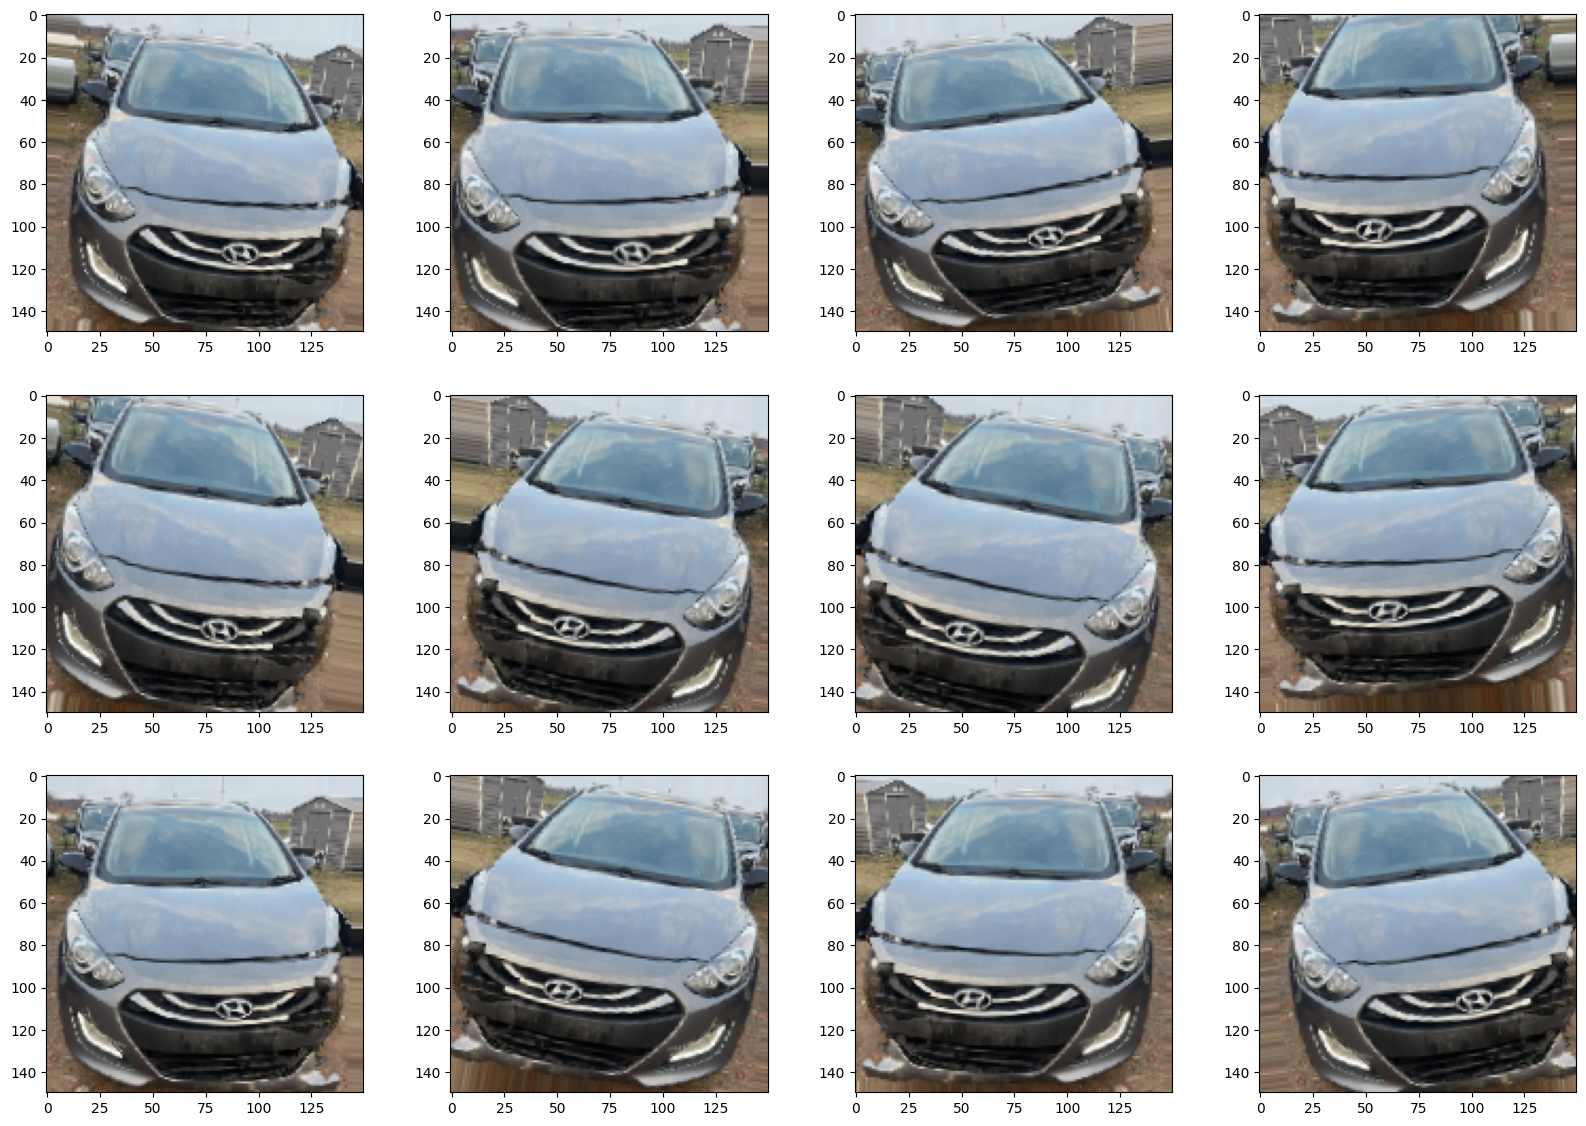

In [ ]:
#@title Wybierz index obrazka w celu jego eksploracji

index = 54 #@param {type:'slider', min:0, max:539}
display_augmented_images('splitted_images/train/damaged_cars', index)

# Trening

## Transfer Learning I (VGG16)

In [ ]:
INPUT_SHAPE

In [ ]:
from keras.applications import VGG16

vgg_model = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=INPUT_SHAPE)

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# zamrożenie warstw
for layer in vgg_model.layers:
    layer.trainable = False


for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
# rozbudowa mdelu
x = vgg_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
transfer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
# kompilacja modelu
transfer_model.compile(optimizer=Adam(),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
train_generator.class_indices

{'damaged_cars': 0, 'ok_cars': 1}

In [ ]:
# trening
MODEL_NAME = 'transfer_VGG_16__'

dt = datetime.now(pytz.timezone('Europe/Warsaw')).strftime('%d_%m_%Y_%H_%M') # aktualna data i czas (znacznik czasu)

filepath = os.path.join('output', 'model_' + f'{MODEL_NAME}_'+ dt + '.hdf5')

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)


history = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight,
    verbose=2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



52/52 - 577s - loss: 0.9185 - accuracy: 0.6539 - val_loss: 0.4126 - val_accuracy: 0.8167 - 577s/epoch - 11s/step
Epoch 2/50
52/52 - 577s - loss: 0.6233 - accuracy: 0.7764 - val_loss: 0.3222 - val_accuracy: 0.8687 - 577s/epoch - 11s/step
Epoch 3/50
52/52 - 577s - loss: 0.5346 - accuracy: 0.8170 - val_loss: 0.3799 - val_accuracy: 0.8292 - 577s/epoch - 11s/step
Epoch 4/50
52/52 - 574s - loss: 0.4593 - accuracy: 0.8467 - val_loss: 0.3122 - val_accuracy: 0.8667 - 574s/epoch - 11s/step
Epoch 5/50
52/52 - 576s - loss: 0.4015 - accuracy: 0.8739 - val_loss: 0.3491 - val_accuracy: 0.8750 - 576s/epoch - 11s/step
Epoch 6/50
52/52 - 572s - loss: 0.3394 - accuracy: 0.8879 - val_loss: 0.3444 - val_accuracy: 0.8479 - 572s/epoch - 11s/step
Epoch 7/50
52/52 - 573s - loss: 0.3666 - accuracy: 0.8836 - val_loss: 0.3012 - val_accuracy: 0.8729 - 573s/epoch - 11s/step
Epoch 8/50
52/52 - 555s - loss: 0.3671 - accuracy: 0.8915 - val_loss: 0.3267 - val_accuracy: 0.8500 - 555s/epoch - 11s/step
Epoch 9/50
52/52 - 

### Eksport wyników trenowania i etykiet do plików

In [ ]:
print('[INFO] Eksport wykresu do pliku html...')
filename = os.path.join('output', 'report_' f'{MODEL_NAME}_'+ dt + '.html')
plot_hist(history, filename=filename, show_plot=True)

[INFO] Eksport wykresu do pliku html...


In [ ]:
# info o mapowaniu klas
print('[INFO] Eksport etykiet do pliku...')
with open(r'output/labels.pickle', 'wb') as file:
    file.write(pickle.dumps(train_generator.class_indices))

[INFO] Eksport etykiet do pliku...


### Sprawdzenie modelu na zbiorze testowym

In [ ]:
check_model(transfer_model, TEST_DIR, INPUT_SHAPE)

Found 239 images belonging to 2 classes.
239/239 [==============================] - 66s 275ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[ 51  25]
 [  4 159]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.93      0.67      0.78        76
     ok_cars       0.86      0.98      0.92       163

    accuracy                           0.88       239
   macro avg       0.90      0.82      0.85       239
weighted avg       0.88      0.88      0.87       239


[INFO] Dokładność modelu: 87.87%

[INFO] Błędnie sklasyfikowano: 29

[INFO] Nazwy plików:
damaged_cars/0014.jpg    0.997392
damaged_cars/0029.jpg    0.746443
damaged_cars/0047.jpg    0.593996
damaged_cars/0068.jpg    0.902535
damaged_cars/0069.jpg    0.686174
damaged_cars/0070.jpg    0.922098
damaged_cars/0091.jpg    0.593088
damaged_cars/0133.jpg    0.650562
damaged_cars/0181.jpg    0.978569
damaged_cars/0217.jpg    0.999868
damaged_cars/0250.jp

### Sprawdzenie modelu na nowym zbiorze testowym (pobrane 19.01.2024)

In [ ]:
!unzip '/content/test_images_19_01_2024.zip'

In [ ]:
new_test_dir = 'test_images_19_01_2024'

In [ ]:
ls

cars_image/  cars_image.zip  output/  sample_data/  splitted_images/  test_images_19_01_2024.zip


In [ ]:
check_model(transfer_model, new_test_dir, INPUT_SHAPE)

Found 60 images belonging to 2 classes.
60/60 [==============================] - 16s 264ms/step

====
{'damaged_cars': 0, 'ok_cars': 1}
====

[INFO] Macierz konfuzji:
[[35  5]
 [ 3 17]]

[INFO] Raport klasyfikacji:
              precision    recall  f1-score   support

damaged_cars       0.92      0.88      0.90        40
     ok_cars       0.77      0.85      0.81        20

    accuracy                           0.87        60
   macro avg       0.85      0.86      0.85        60
weighted avg       0.87      0.87      0.87        60


[INFO] Dokładność modelu: 86.67%

[INFO] Błędnie sklasyfikowano: 8

[INFO] Nazwy plików:
damaged_cars/01.jpg    0.950341
damaged_cars/02.jpg    0.917475
damaged_cars/18.jpg    0.942051
damaged_cars/25.jpg    0.960858
damaged_cars/35.jpg    0.743399
ok_cars/115.jpg        0.356082
ok_cars/116.jpg        0.399058
ok_cars/117.jpg        0.117935
Name: y_prob, dtype: float32


### sprawdzenie modelu na pojedynczym zdjęciu

1/1 [==============================] - 0s 455ms/step
y_pred: 0.5642063617706299
ok_cars


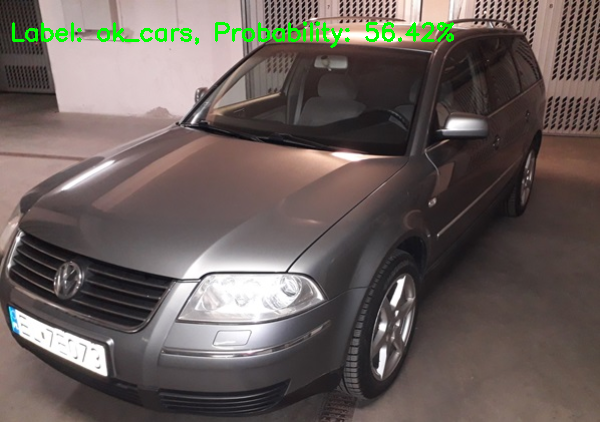

In [ ]:
predict_class('/content/pasek.jpg', transfer_model, INPUT_SHAPE, '/content/output/labels.pickle')

1/1 [==============================] - 0s 250ms/step
y_pred: 0.5918243527412415
ok_cars


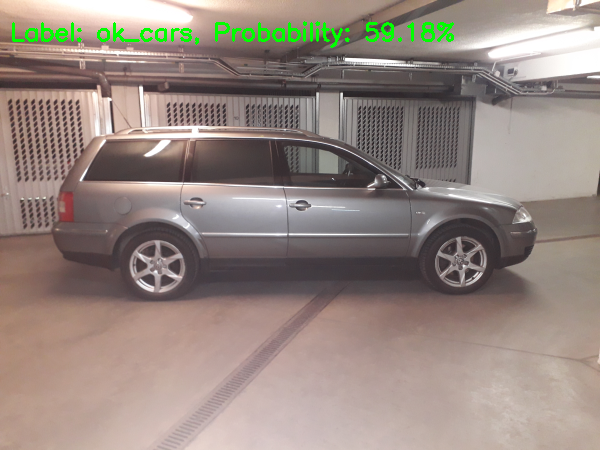

In [ ]:
predict_class('/content/pasek2.jpg', transfer_model, INPUT_SHAPE, '/content/output/labels.pickle')

1/1 [==============================] - 0s 250ms/step
y_pred: 0.014176744967699051
damaged_cars


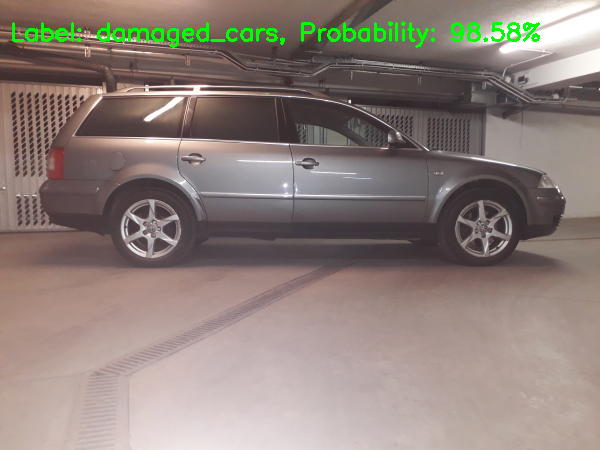

In [ ]:
predict_class('/content/pasek3.jpg', transfer_model, INPUT_SHAPE, '/content/output/labels.pickle')

1/1 [==============================] - 0s 258ms/step
y_pred: 0.9995179176330566
ok_cars


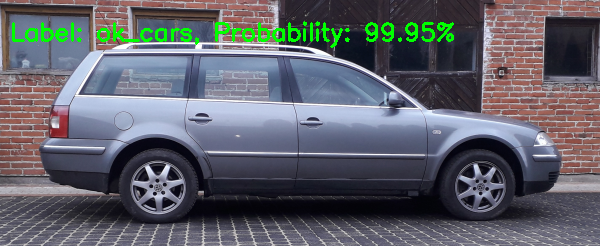

In [ ]:
predict_class('/content/passat_2020.jpg', transfer_model, INPUT_SHAPE, '/content/output/labels.pickle')

1/1 [==============================] - 0s 244ms/step
y_pred: 0.021782632917165756
damaged_cars


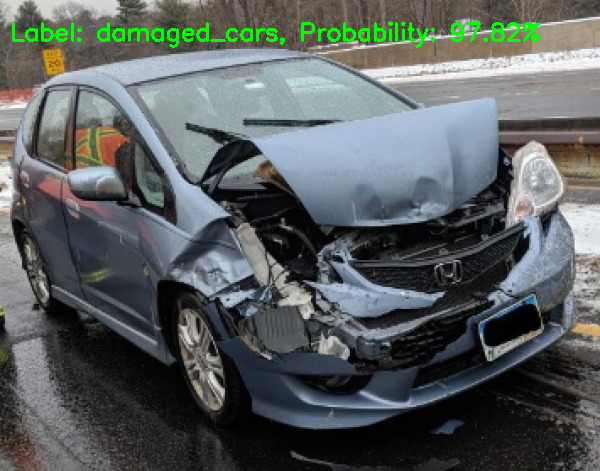

In [ ]:
predict_class('/content/d1.jpg', transfer_model, INPUT_SHAPE, '/content/output/labels.pickle')

# Heatmap

In [ ]:
pip install tf-keras-vis tensorflow

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

### Wczytanie modelu i etykiet

In [ ]:
loaded_model = load_model('custom_VGG16_model_2_classes.hdf5')
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
with open('labels.pickle', 'rb') as file:
    classes = pickle.loads(file.read())

labels = dict(enumerate(classes))
labels

{0: 'damaged_cars', 1: 'ok_cars'}

### Zmiana funkcji aktywacji w ostatniej warstwie (na liniową)

In [ ]:
loaded_model.layers[-1].activation

<function keras.src.activations.linear(x)>

In [ ]:
# define the model modifier - change the activation function
def model_modifier(mdl):
    mdl.layers[-1].activation = tf.keras.activations.linear # we change the activation function of last layer to linear

In [ ]:
# create an object

gradcam = Gradcam(loaded_model,
                model_modifier=model_modifier,
                clone=False)

In [ ]:
loaded_model.layers[-1].activation

<function keras.src.activations.linear(x)>

### Przygotowanie zdjęcia do predykcji

In [ ]:
INPUT_SHAPE = (224, 224, 3)

In [ ]:
image_path = 'ok4.jpg'

my_image = cv2.imread(image_path)
my_image = cv2.resize(my_image, (INPUT_SHAPE[0], INPUT_SHAPE[1]))
my_image = my_image.astype('float') / 255.
my_image = img_to_array(my_image)
my_image = np.expand_dims(my_image, axis=0)


# predykcja
y_pred = loaded_model.predict(my_image)
print(y_pred)
predicted_class = np.argmax(y_pred)
print(f'Predicted class: {predicted_class} -> {labels[predicted_class]}')

1/1 [==============================] - 1s 753ms/step
[[0.00941932 0.99058074]]
Predicted class: 1 -> ok_cars


In [ ]:
# zapis wyniku predykcji i prawdopodobieństwa
score = CategoricalScore(predicted_class)
input_class = 'ok_cars' if predicted_class == 1 else 'damaged_cars'
probability = y_pred[0][0] if np.argmax(y_pred) == 0 else y_pred[0][1]

### Część właściwa

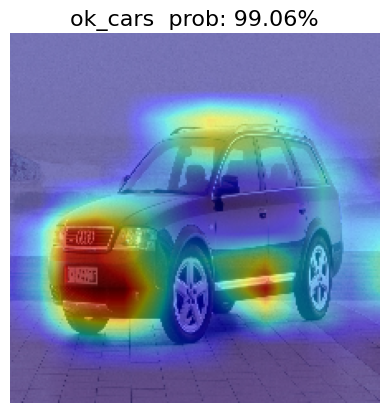

In [ ]:
# utworzenie heatmapy
cam = gradcam(score,
              my_image,
              penultimate_layer=-1)




fig, ax = plt.subplots()#(nrows=1, ncols=4, figsize=(12, 4))
heatmap = np.uint8(cm.jet(cam[0])[..., :4] * 255)
#heatmap = cv2.applyColorMap(heatmap , cv2.COLORMAP_JET)
ax.set_title(input_class + f'  prob: {probability * 100:.2f}%', fontsize=16)
ax.imshow(my_image[0])
ax.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax.axis('off')
plt.show()